In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, bernoulli

# Using the Beta distribution to model behaviors of agents
***

Let us consider a collection of agents that are either blue (`blue=1`), or not blue (`blue-0`). Whether or not an agent is blue is random, however, the probability of them becoming blue or not is dependent on other things around it.

We may not know exactly how or why agents become `blue=1`, but if we are to create a simulation of these agents, we would like to be able to model the behavior of this `blue` attribute over the course of the simulation. In some cases, `blue` may affect other things as well.

### Problem: Agents may have attributes/behaviors that are stochastic AND dynamic. How do we model this dynamic stochastic behavior?
***

### Prior and posterior distributions and Bayesian updating of hyperparameters
Below I go over some basics on using information/observations to update the probability distribution of an unknown random variable. If this is familiar to you, you can skip it. Note how this is NOT what we are doing with our model of `blue` for the agents, but it is important to understand and helps develop the intuitive understanding of the Beta distribution and its parameters.

Consider a simulation of $N$ agents. Let each agent in our simulation have a feature which we will call `blue`. In this scenario, for each $i=1, \ldots, N$, `blue` is a binary random variable $X_i$ that is either $X_i=0$, with probability $1-p$, or $X_i=1$, with probability $p$, where $p$ is an unknown random variable. That is, the attribute of being blue for each $i^{th}$ agent is $X_i\sim Bernoulli(p)$ where $p$ is an ***unknown random variable.***

$X_1, \ldots, X_N$ is a random sample of $N$ Bernoulli random variables with parameter $p$, where $p$ is unkown. Let us assume that the prior distribution of $p$ is $p\sim B(\alpha_0, \beta_0)$ with prior probability density function $\xi$. If $x = (X_1 = x_1, \ldots, X_N = x_N)$ and the likelihood of observing $x$ given $p$ is $f(x_1|p)\cdots f(x_N|p) = f_N(x|p)$, then the posterior proabiity density function of $p$ after observing $x$ is
$$\xi(p|x) = \frac{f_N(x|p) * \xi(p)}{\int_0^1 f_N(x|p)\xi(p)dp}$$

We can find the updating rule for the posterior with a bit of math. Let $g_N(x) = \int_0^1 f_N(x|p)\xi(p)dp$ and consider, 
$$\xi(p|x) = \frac{f_N(x|p) * \xi(p)}{g_N(x)}$$
Evaluating $f_N(x|p)$ now,
$$f_N(x|p) = \prod_{i=1}^N p^{x_i}(1-p)^{x_i} = p^{\sum_{i=1}^Nx_i}(1-p)^{N - \sum_{i=1}^Nx_i} = p^y(1-p)^{N-y}$$
where $y = \sum_{i=1}^N x_i$. 

Expanding $\xi(p)$ now, $$ \frac{\Gamma(\alpha_0 + \beta_0)}{\Gamma(\alpha_0)\Gamma(\beta_0)}p^{\alpha_0-1}(1-p)^{\beta_0-1}  $$
Putting this together, we get
$$\xi(p|x) = \frac{\Gamma(\alpha_0 + \beta_0)}{g_N(x)\Gamma(\alpha_0)\Gamma(\beta_0)}p^{\alpha_0+y-1}(1-p)^{\beta_0+N-y-1} $$
Since $g_N(x)$ is a constant term, this shows that $\xi(p|x)$ is proportional to a Beta distribution with parameters $\alpha_1 = \alpha_0 + y$ and $\beta_1 = \beta_0 + N - y$. The constant terms do work out to $\frac{\Gamma(\alpha_0 + \beta_0 + N)}{\Gamma(\alpha_0 + y)\Gamma(\beta_0+N-y)}$ but I omit the work for it.

Therefore, the posterior of $p\sim B(\alpha_1, \beta_1)$.

Now, this is how we update the posterior distribution of a parameter given observations of data. Hence, ***posterior***. But what we would like is to model behvaiors of stochastic agents depending on different values of states of the model. Therefore, the updating rule will be a function we modify and define in order to most accurately and realistically update the posterior distribution, which models the stochastic behavior of our agents.

Here we run through sum code using `scipy.stats` in order to illustrate what posterior updating looks like in code. For our first example, we will assume that $p$ is an unknown random variable rather than dynamically changing $p$ over the course of the simulation. 

In [3]:
# determine/get size of random sample
N = 1000

# true form of p
p = beta.rvs(1, 999, size=N)

# initialize alpha_0, beta_0 parameters, these are the hyperparameters of the prior of p
alpha0, beta0 = 1, 1

# print every 20th value of the p vector
print(p[::20])

[4.85331871e-04 1.92402889e-04 2.33398203e-04 8.37070349e-04
 1.71633760e-04 1.83657798e-03 2.45068060e-04 2.33552926e-03
 9.29983575e-04 1.77710654e-03 6.39009997e-04 1.57715349e-03
 5.73428638e-04 4.81148798e-04 3.42640304e-04 2.84113886e-04
 4.64121773e-04 8.35582736e-04 1.30069520e-03 1.33188477e-03
 8.74801853e-04 4.35914478e-04 7.99958522e-04 6.75397174e-05
 6.75888525e-04 4.54279886e-04 1.88503371e-04 8.12762077e-04
 2.70751915e-04 8.54071587e-04 1.14915104e-03 7.79961936e-04
 3.23186530e-04 4.93598605e-04 9.71416142e-04 6.76497015e-04
 5.84090507e-05 6.68991227e-04 9.75878953e-04 8.56861556e-04
 1.00601115e-03 1.19048118e-03 9.94096516e-05 2.12986487e-03
 5.33897650e-04 2.56359450e-04 7.56131786e-04 2.81633672e-05
 1.39052536e-03 7.60826419e-04]


Notice how the values of $p\in \mathbb{R}^{1000}$ are all ***very*** close to $0$. 

This is because our prior distribution with $\alpha_{true}=1, \beta_{true}=999$ has an expected value of $\mathbb{E}(p) = \frac{\alpha_{true}}{\alpha_{true} + \beta_{true}} = \frac{1}{1000} = 0.001$

Now, we observe the data $x = (X_1=x_1, \ldots, X_{1000}=x_{1000})$. Since the expected value of $p$ is $0.001$, we expect that most of the $x_i$ are $0$.

In [4]:
blue = bernoulli.rvs(p)
#print(blue)

First, notice that `scipy` allows us to pass in a vector of parameter values for Bernoulli random variables. That is, for each $i = 1, \ldots, 1000$, the $i^{th}$ entry of blue is a random variable $X_i\sim Bernoulli(p_i)$, where $p_i$ is the $i^{th}$ entry of $p\in \mathbb{R}^{1000}$.

Second, run the code above a few times and print out `blue` each time. Notice how it is different each time and also how it is primarily made up of $0$. This is because the $p_i$ for each $X_i$ is ***expected*** to be around $0.001$ and thus, each $X_i$ is expected to take the value of $1$ with probability around $0.001$. With $1000$ entries of `blue`, from our values, we would expect one $1$ on average, but don't be alarmed if there are more or less (maybe be alarmed if there are lots of ones!).

Great, we have a vector of `blue`. $1$ if they are blue and $0$ if they are not. Counting the number of agents that are blue is simple, we just sum across the vector. The number of not blue agents will be $1000 - y$ where $y$ is the number of blue agents.

In [5]:
num_blue = np.sum(blue)
num_not_blue = N - num_blue
print(f"The total number of blue agents is: {num_blue}")
print(f"The total number of not blue agents is: {num_not_blue}")

The total number of blue agents is: 1
The total number of not blue agents is: 999


Now, we update the values of $\alpha_0, \beta_0$ and repeat!

In [6]:
alpha1, beta1 = alpha0 + num_blue, beta0 + N - num_blue

Here I implement a loop in order to illustrate this iterative process. Assume the number of iterations is $n$ (don't confuse $n$ and $N$!)

In [7]:
N = 1000 # number of random variables in a random sample
n = 1000 # number of random samples
alpha0, beta0 = 1, 999 # true alpha, beta hyperparameters
a, b = 1, 1 # initial hyperparameters for initial prior of p
p = beta.rvs(alpha0, beta0, size=N)

for i in range(n):
    x = bernoulli.rvs(p)
    y = np.sum(x)
    a, b = a + y, b + N - y

In [8]:
print(f"The true hyperparameters: {(alpha0, beta0)}\n")
print(f"The last updated hyperparameters after n observations: {(a, b)}\n")
x = bernoulli.rvs(p)
x_estimated = bernoulli.rvs(beta.rvs(a, b, size=N))
print(f"The number of ones from an observation of X: {np.sum(x)}")
print(f"The number of ones from an observation of our estimate of X: {np.sum(x_estimated)}")
print(f"The expected value of p is: {beta.mean(1, 999)}")
print(f"The expected value of p_estimated is: {beta.mean(a, b)}")
#print(N - np.sum(x))
#print(N - np.sum(x_estimated))

The true hyperparameters: (1, 999)

The last updated hyperparameters after n observations: (975, 999027)

The number of ones from an observation of X: 1
The number of ones from an observation of our estimate of X: 0
The expected value of p is: 0.001
The expected value of p_estimated is: 0.0009749980500039


So we started off with a TERRIBLE initial guess as to what $p$ looks like but eventually converged to a random variable that is similar in shape and close in expected value. In fact, we can plot these distributions and compare.

C:\Users\Teddy\AppData\Local\Temp\ipykernel_17664\3903449816.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


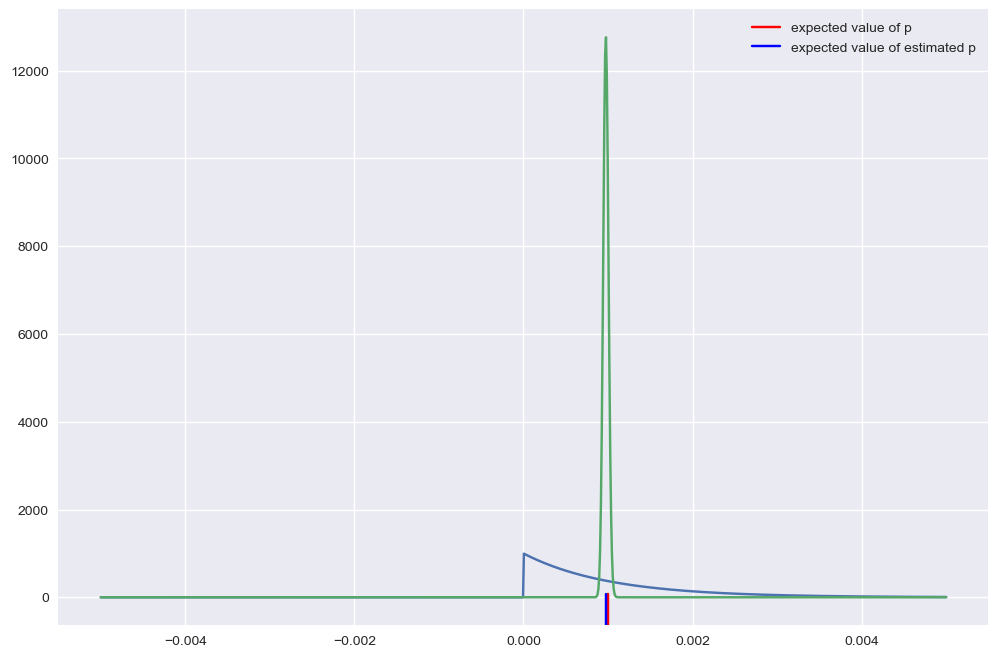

In [9]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

x = np.linspace(-0.005, 0.005, 1000)
beta_pdf = beta.pdf(x, alpha0, beta0)
beta_pdf_est = beta.pdf(x, a, b)
plt.axvline(x=beta.mean(alpha0, beta0), ymin=0, ymax=0.05, color='r', label='expected value of p')
plt.axvline(x=beta.mean(a, b), ymin=0, ymax=0.05, color='b', label='expected value of estimated p')
plt.legend()

plt.plot(x, beta_pdf)
plt.plot(x, beta_pdf_est)
plt.show()

***
### How is this useful this for modeling agents?
This is important to understand in order to understand the behavior of the parameters of Beta. One of the most important things to notice about this updating method is that the ***information of previous value of $alpha$ and $\beta$ is dynamically stored***. This can be useful in our simulation because the probability distributions of behaviors of agents should certainly depend on the current and previous states/probabilities of that agent.

For our purposes, that's NOT what we want to do. We want to change $p$ over time along with $\alpha_0, \beta_0$ in order to simulate the agents in a realistic manner. Let's see what happens when we add in some terms that increase or decrease the hyperparameters and adjust $p$ along the way. Feel free to mess around with these.

In [10]:
def dynamic(a, b, d, t, y, N):
    
    return max(1, a + y + d - t), max(1, b + N - y - d + t)

In [11]:
def D(d, t):
    if t < 5000:
        return d+1.1
    else:
        return d-1

In [12]:
t = 0
d = 0

N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
alpha0, beta0 = 1, 999 # initial alpha, beta hyperparameters
yab_list = [] # keeps track the number of blues per iteration

for i in range(n):
    d = D(d, i+1)
    p = beta.rvs(alpha0, beta0, size=N)
    x = bernoulli.rvs(p)
    y = np.sum(x)
    alpha0, beta0 = dynamic(alpha0, beta0, d, i+1, y, N)
    if i % 20 == 0:
        yab_list.append((y, alpha0, beta0))

In [13]:
print(alpha0, beta0)
print(yab_list)
max_yab = max(yab_list)
last_yab = yab_list[-1]
print(f"\nThe tuple with the max number of 1's is:\n{max_yab}\n")
print(f"The max expected value of p in our list is:\n{beta.mean(max_yab[1], max_yab[2])}\n")
print(f"The last tuple is:\n{last_yab}\n")
print(f"The last expected value of p over this loop is was:\n{beta.mean(last_yab[1], last_yab[2])}\n")

1 29290645.100001
[(0, 1.1, 1998.9), (1, 44.099999999999994, 21955.9), (7, 179.10000000000034, 41820.9), (11, 417.10000000000116, 61582.9), (11, 708.1000000000007, 81291.9), (6, 1087.0999999999979, 100912.9), (9, 1529.0999999999929, 120470.9), (12, 2028.0999999999858, 139971.9), (12, 2603.099999999977, 159396.9), (20, 3280.099999999966, 178719.9), (22, 4040.099999999953, 197959.9), (15, 4881.099999999938, 217118.9), (31, 5812.09999999992, 236187.9), (29, 6817.09999999991, 255182.9), (26, 7919.099999999909, 274080.9), (30, 9124.099999999919, 292875.9), (38, 10363.099999999937, 311636.9), (31, 11711.099999999964, 330288.9), (34, 13112.099999999999, 348887.9), (29, 14593.100000000044, 367406.9), (43, 16157.100000000097, 385842.9), (37, 17828.10000000016, 404171.9), (45, 19598.10000000023, 422401.9), (50, 21366.100000000315, 440633.9), (40, 23222.100000000402, 458777.9), (35, 25177.100000000504, 476822.9), (50, 27219.10000000061, 494780.9), (53, 29316.100000000726, 512683.8999999999), (60,

Notice how the ***expected*** value of $p$ for the tuple that contains the max number of `blue` agents is a whopping $\approx 0.5$. If you look at the $\alpha_0, \beta_0$ values at the end of the list, you'll notice that it gives a Beta distribution that is centered very closely to $0$. Meaning the Beta distribution ***grew*** then ***shrank*** kind of like how, given some increase and decrease in some variable, we expect the probability of being `blue` to shape and scale accordingly.

Below we illustrate this again and plot the expected values of $p$ versus time.

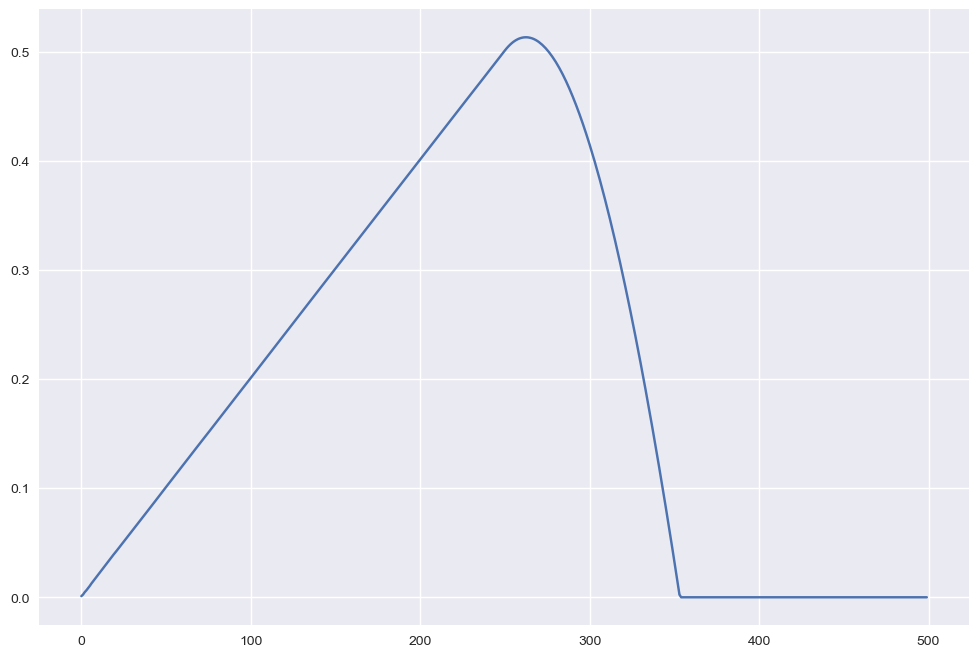

In [14]:
d = 0

N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
t = np.arange(0, n//20) # array of time steps from 0 to n-1
alpha0, beta0 = 1, 999 # initial alpha, beta hyperparameters
exp_list = [] # keeps track of the expected value of p

#exp_list.append(beta.mean(alpha0, beta0))

for i in range(n):
    d = D(d, i+1)
    p = beta.rvs(alpha0, beta0, size=N)
    x = bernoulli.rvs(p)
    y = np.sum(x)
    alpha0, beta0 = dynamic(alpha0, beta0, d, i+1, y, N)
    if i % 20 == 0:
        exp_list.append(beta.mean(alpha0, beta0))
        
        
plt.plot(t, exp_list)
plt.show()

As we can see, $\mathbb{E}(p)$ grew up to slightly above $0.5$ and then shrank quickly back down to close to $0$. We can tune and modiy this code, the `dynamic` function, and do many other things in order to more accurately model how we expect the agents to behave using our own intuition and knowledge.

This is useful because rather than determining the behavior of these agents, which are almost always stochastic in nature, we assume the agents in our model act on a behavior in a random way that is dependent on a parameter that is ***also*** random and we adjust the hyperparameters of that random variable according to some states, information, etc. that we believe would modify the ***probability*** of an agent acting on a behavior.
***

### Conclusions:
That's about all there is to say about this methodology. Below is some code I was messing around with to look at how the distributions change over time.

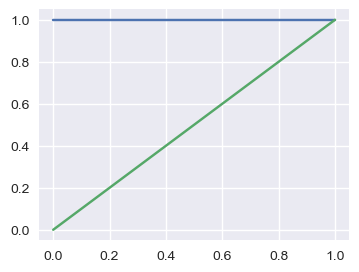

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\scipy\stats\_continuous_distns.py:670: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)
c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\scipy\stats\_continuous_distns.py:678: RuntimeWarning: divide by zero encountered in _beta_cdf
  return _boost._beta_cdf(x, a, b)


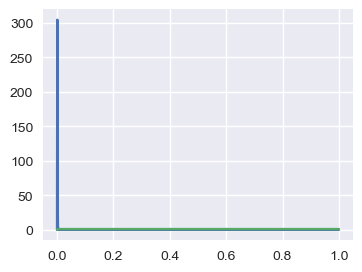

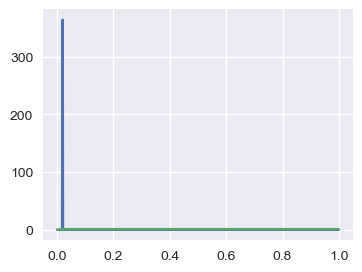

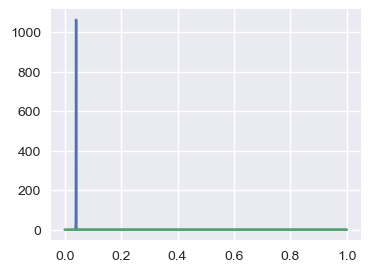

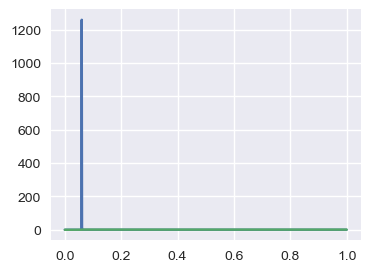

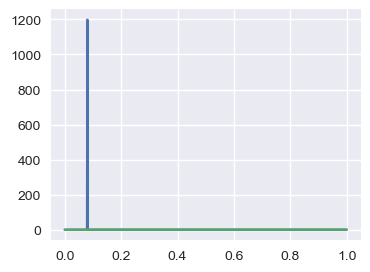

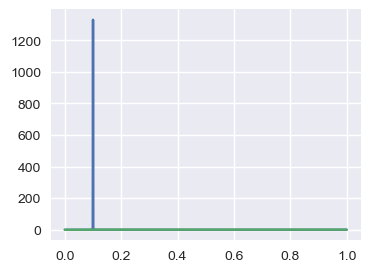

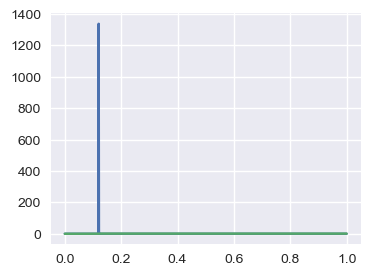

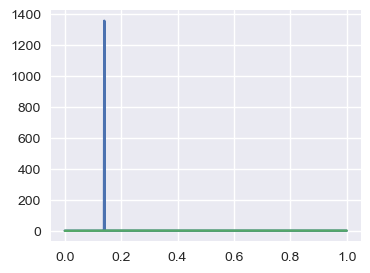

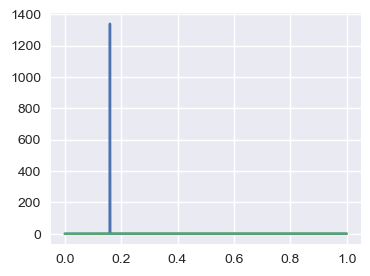

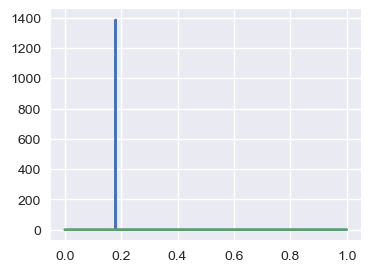

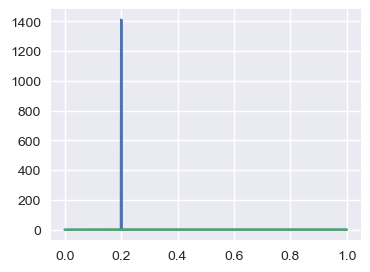

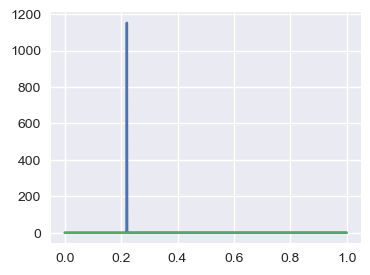

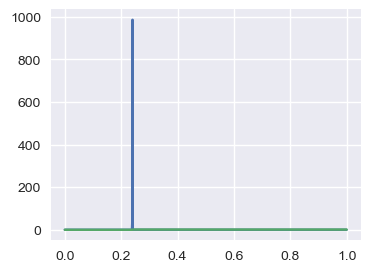

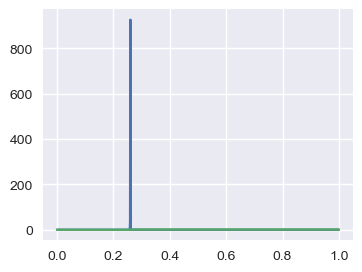

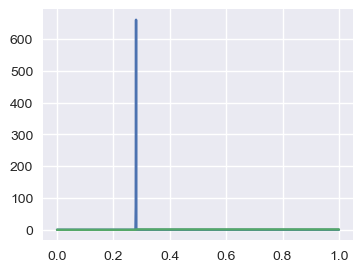

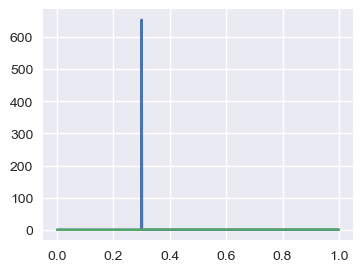

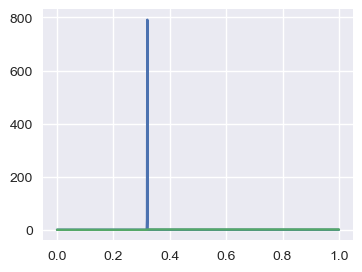

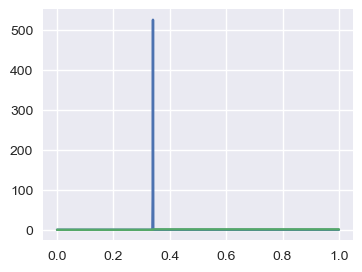

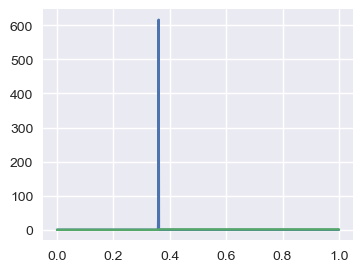

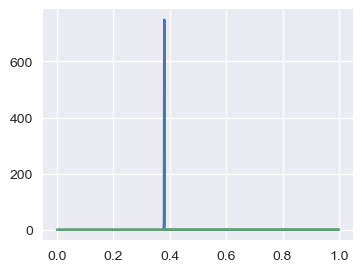

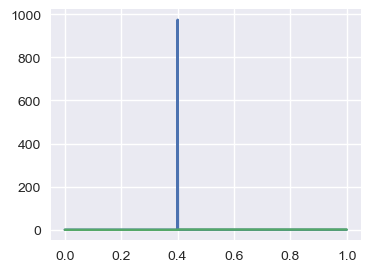

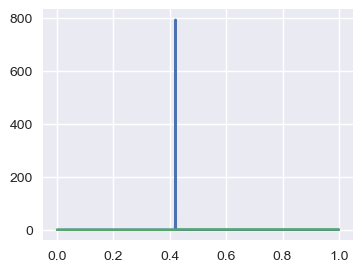

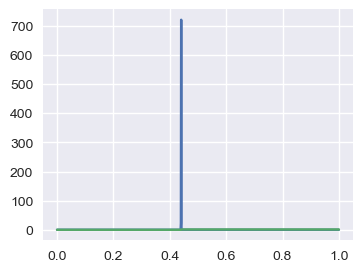

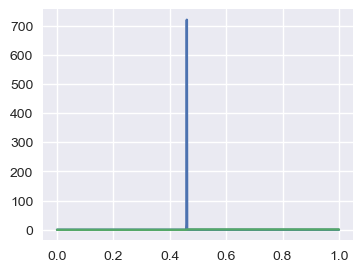

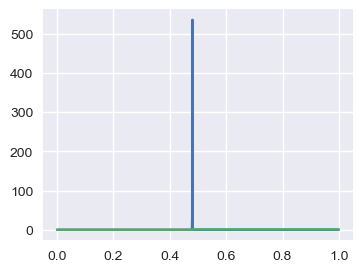

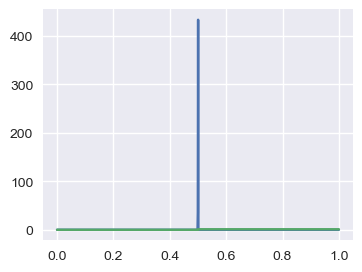

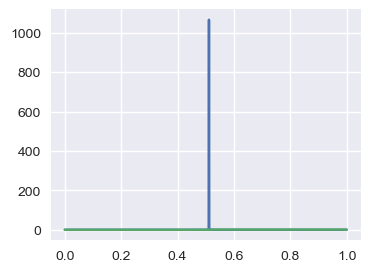

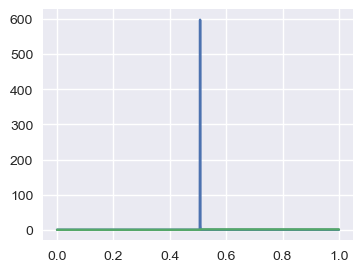

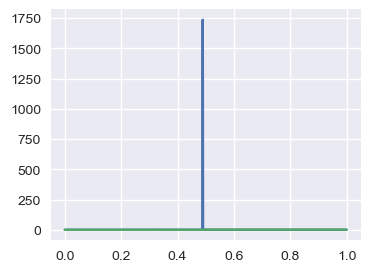

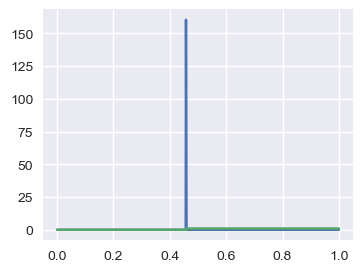

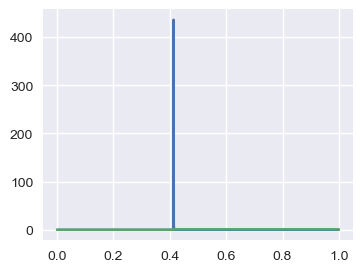

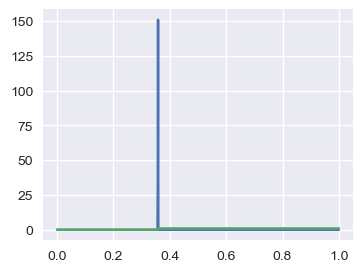

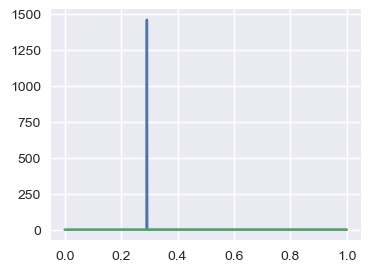

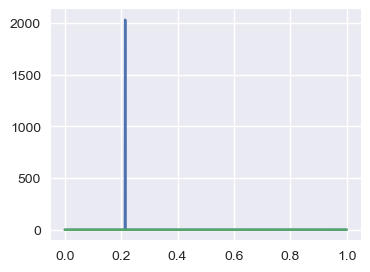

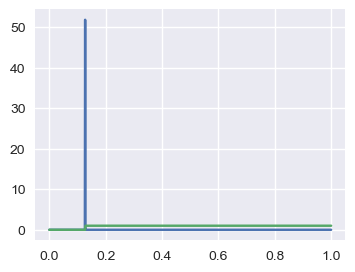

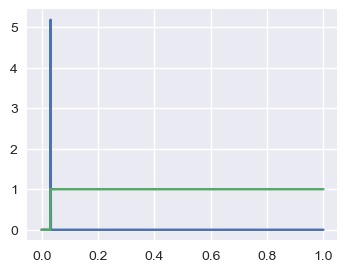

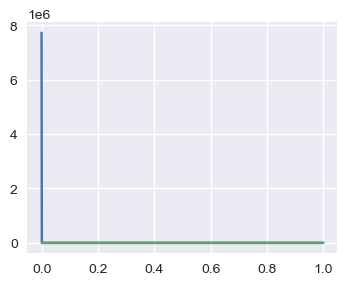

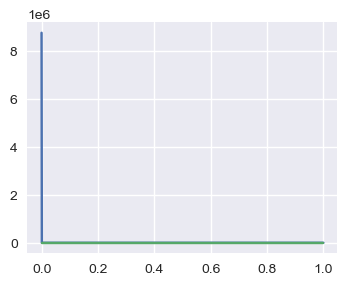

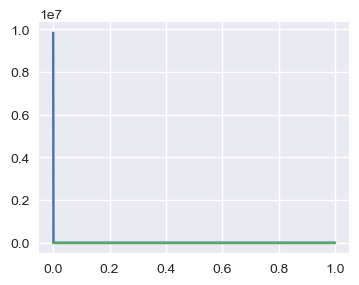

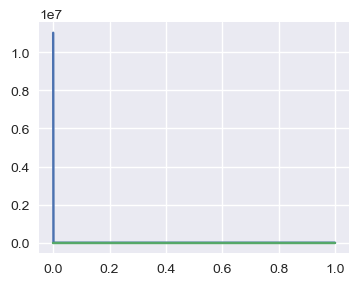

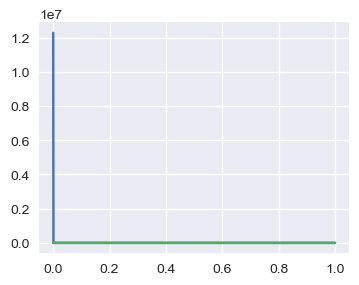

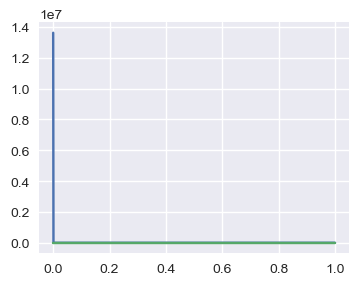

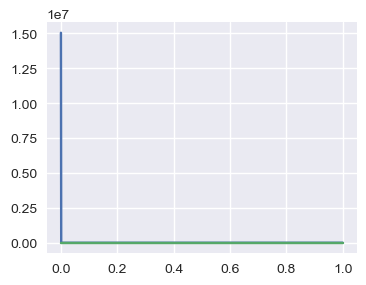

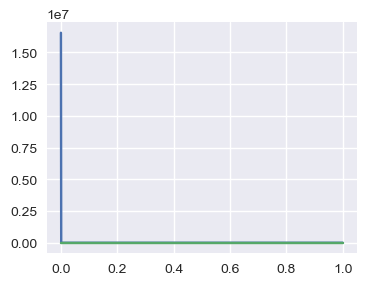

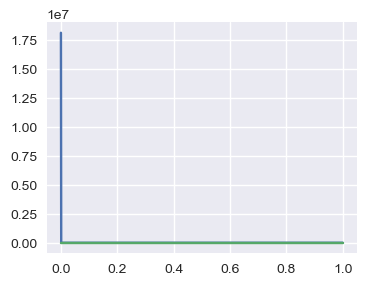

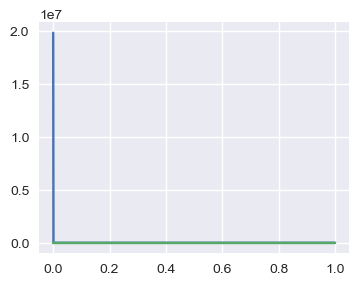

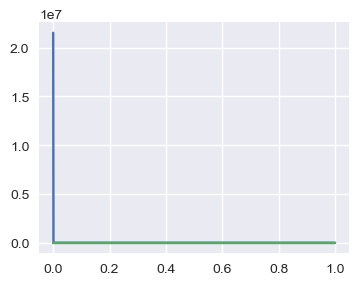

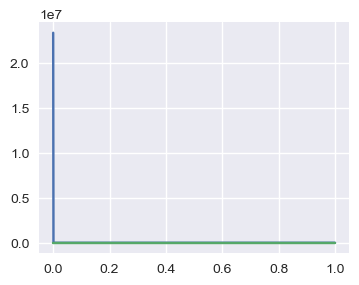

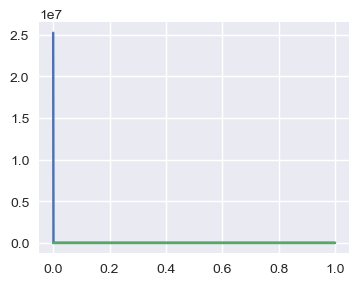

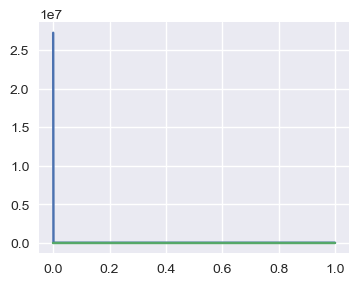

In [16]:
plt.rcParams['figure.figsize'] = (4, 3)

t = 0
d = 0

N = 1000 # number of random variables in a random sample
n = 10000 # number of random samples
alpha0, beta0 = 1, 999 # initial alpha, beta hyperparameters
yab_list = [] # keeps track the number of blues per iteration

xt = np.linspace(0, 1, 1000)
beta_pdf = beta.pdf(xt, 1, 1)
beta_cdf = beta.cdf(xt, 1, 1)
plt.plot(xt, beta_pdf)
plt.plot(xt, beta_cdf)
plt.show()
plt.close()

for i in range(n):
    d = D(d, i+1)
    p = beta.rvs(alpha0, beta0, size=N)
    x = bernoulli.rvs(p)
    y = np.sum(x)
    alpha0, beta0 = dynamic(alpha0, beta0, d, i+1, y, N)
    if i % 200 == 0:
        yab_list.append((y, alpha0, beta0))
        
        beta_pdf = beta.pdf(xt, alpha0, beta0)
        beta_cdf = beta.cdf(xt, alpha0, beta0)

        plt.plot(xt, beta_pdf)
        plt.plot(xt, beta_cdf)
        plt.show()
        plt.close()